In [1]:
import logging
class Complex():
    """
    A class relating the vertexes of a hypercomplex of hypersimplices without
    physical storage by exploiting the symmetry of the simplicial powerset.
    """
    def __init__(self, dim=2):
        import numpy
        self.V = []
        self.S = []  # Face indexes, edges = 1 face
        self.I = []  # Index sets
        self.i_gen = [] 
        self.i_current = [] 
        for i in range(dim + 1):
            self.S.append([])
            self.I.append([])
            self.i_gen.append(self.index_gen())     
            self.i_current.append(0)  
            
        #self.I_V = numpy.linspace(0, dim**2)
        
        # Intiate first generation of vertices
        #V      
            
    def n_cube(self, dim):
        """
        Generate the simplicial triangulation of the n cube
        containing 2**n vertices
        """
        pass
        
    def generate_vertex(self, x):
        """
        x: vector of cartesian coordinates
        """
        self.V.append(x)
        self.i_current[0] = next(self.i_gen[0])
        logging.info('self.i_current[0] = {}'.format(self.i_current[0]))
        self.I[0].append(self.i_current[0])
        
        
    def generate_simplex(self, V_i, k=1):
        """
        V_i: Tuple containing the indexes of vertices to connect
        """
        self.S[k].append(V_i)
        self.i_current[k] = next(self.i_gen[k])  
        logging.info('self.i_current[k] = {}'.format(self.i_current[k]))
        self.I[k].append(self.i_current[k])
        
    def destroy_simplex(self, ind):
        """
        Delete faces from lists to free up memory
        """
            
    def index_gen(self):
        ind = 0
        while True:
            yield ind
            ind += 1
            
    # incidence arrays
    
    # plots
    def plot_vertexes(self, V):
        return
    
    def plot_graph(self):
        from matplotlib import pyplot
        %matplotlib nbagg
        pyplot.figure()
        for v in HC.V:
            pyplot.plot([v[0]], [v[1]], 'o')

        for f in HC.S[1]:
            #print(HC.V[f[0]], HC.V[f[1]])
            pyplot.plot([HC.V[f[0]][0], HC.V[f[1]][0]],
                          [HC.V[f[0]][1], HC.V[f[1]][1]], 'r-')

        pyplot.ylim([-1e-2, 1+1e-2])
        pyplot.xlim([-1e-2, 1+1e-2])
        pyplot.show()
        return
    
    #def plot_
                  
        
    def print_complex(self):
        print('Index set I = {}'.format(self.I))
        print('Vertices V = {}'.format(self.V))
        print('Simplices S = {}'.format(self.S))
            
HC = Complex()
HC.I

#HC.index_gen()
#index = HC.index_gen()
next(HC.i_gen[0]), next(HC.i_gen[0]), next(HC.i_gen[1]), next(HC.i_gen[0]), next(HC.i_gen[1])

(0, 1, 0, 2, 1)

In [2]:
HC = Complex()
HC.I
HC.generate_vertex([0, 0])  # 0
HC.generate_vertex([0, 1])  # 1
HC.generate_vertex([1, 0])  # 2
HC.generate_vertex([1, 1])  # 3
#HC.generate_vertex([0.5, 0.5])

# Generate edges
HC.generate_simplex([0, 1], k=1)
HC.generate_simplex([0, 2], k=1)
HC.generate_simplex([0, 3], k=1)
HC.generate_simplex([1, 3], k=1)
HC.generate_simplex([2, 3], k=1)
#@HC.generate_face([3, 1], k=1)

# Generate k=2 faces
HC.generate_simplex([0, 1, 3], k=2)
HC.generate_simplex([0, 2, 3], k=2)

# Print resulting structure
HC.I, HC.V, HC.S

([[0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1]],
 [[0, 0], [0, 1], [1, 0], [1, 1]],
 [[], [[0, 1], [0, 2], [0, 3], [1, 3], [2, 3]], [[0, 1, 3], [0, 2, 3]]])

<IPython.core.display.Javascript object>


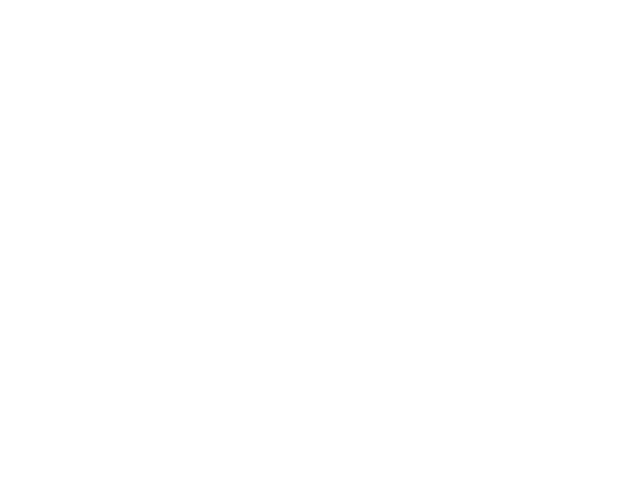

In [3]:
HC.plot_graph()

Initial complex generation
==

Index set I = [[0, 1, 2], [0, 1, 2], [0]]
Vertices V = [[0, 0], [1, 1], [0, 1]]
Simplices S = [[], [[0, 1], [1, 2], [0, 2]], [[0, 1, 2]]]


<IPython.core.display.Javascript object>


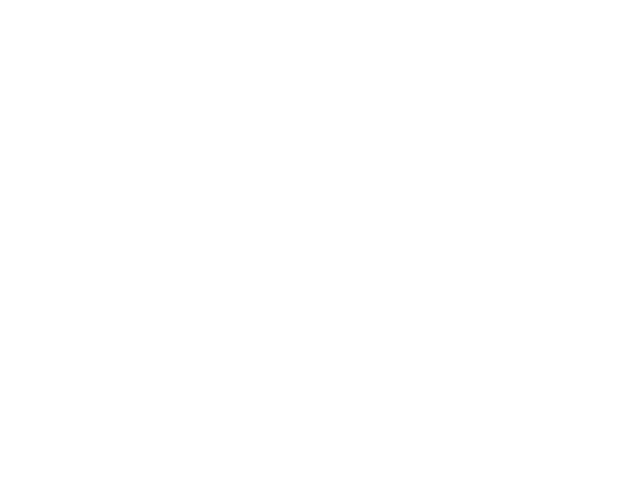

In [4]:
HC = Complex()
HC.I
HC.generate_vertex([0, 0])  # 0
HC.generate_vertex([1, 1])  # 1

# generate first edge
HC.generate_simplex([0, 1], k=1)

#----
# Move down once in first dimension:
HC.generate_vertex([0, 1])  # 2

# generate new edge between 1 and (new vertex)
HC.generate_simplex([1, HC.i_current[0] ]
                 , k=1)

# Move back to 0: New edge
HC.generate_simplex([0, HC.i_current[0] ], k=1)

# Finally get a k=2 face
# Generate k=2 faces
HC.generate_simplex([0, 1, HC.i_current[0]], k=2)

# Print resulting structure
HC.print_complex()
HC.plot_graph()

Index set I = [[0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1]]
Vertices V = [[0, 0], [1, 1], [0, 1], [1, 0]]
Simplices S = [[], [[0, 1], [1, 2], [0, 2], [1, 3], [0, 3]], [[0, 1, 2], [0, 1, 3]]]


<IPython.core.display.Javascript object>


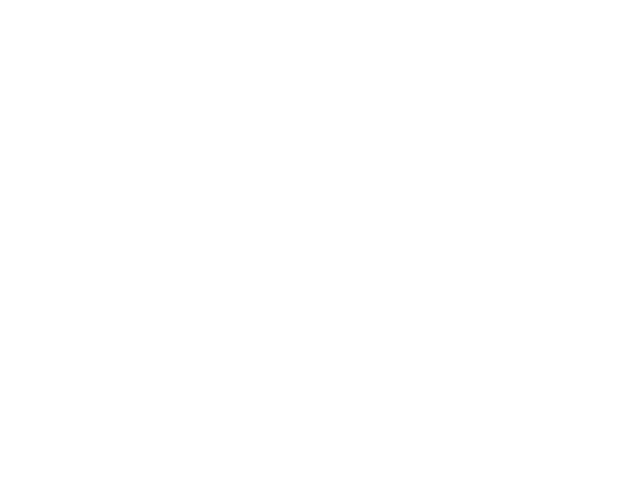

In [5]:
#----
# Starting from V_1 = [1, 1], move down in the second dimension:
HC.generate_vertex([1, 0])  # 2

# generate new edge between 1 and (new vertex)
HC.generate_simplex([1, HC.i_current[0] ]
                 , k=1)

# Move back to 0: New edge
HC.generate_simplex([0, HC.i_current[0] ], k=1)

# Finally get a k=2 face
# Generate k=2 faces
HC.generate_simplex([0, 1, HC.i_current[0]], k=2)

# Print resulting structure
HC.print_complex()
HC.plot_graph()

Index set I = [[0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1]]
Vertices V = [[0, 0], [1, 1], [0, 1], [1, 0]]
Simplices S = [[], [[0, 1], [1, 2], [0, 2], [1, 3], [0, 3]], [[0, 1, 2], [0, 1, 3]]]


<IPython.core.display.Javascript object>


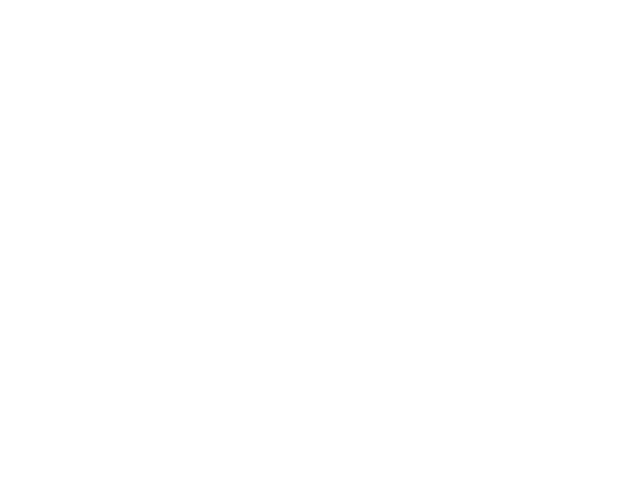

In [6]:
HC = Complex()
HC.I
HC.generate_vertex([0, 0])  # 0
HC.generate_vertex([1, 1])  # 1

# generate first edge
HC.generate_simplex([0, 1], k=1)

#----
# Move down once in first dimension:
HC.generate_vertex([0, 1])  # 2

# generate new edge between 1 and (new vertex)
HC.generate_simplex([1, HC.i_current[0] ]
                 , k=1)

# Move back to 0: New edge
HC.generate_simplex([0, HC.i_current[0] ], k=1)

# Finally get a k=2 simplex
# Generate k=2 simplex
HC.generate_simplex([0, 1, HC.i_current[0]], k=2)

#----
# Starting from V_1 = [1, 1], move down in the second dimension:
HC.generate_vertex([1, 0])  # 2

# generate new edge between 1 and (new vertex)
HC.generate_simplex([1, HC.i_current[0] ]
                 , k=1)

# Move back to 0: New edge
HC.generate_simplex([0, HC.i_current[0] ], k=1)

# Finally get a k=2 simplex
# Generate k=2 faces
HC.generate_simplex([0, 1, HC.i_current[0]], k=2)

# Print resulting structure
HC.print_complex()
HC.plot_graph()

Index set I = [[0, 1, 2, 3], [0, 1, 2, 3, 4], [0, 1]]
Vertices V = [[0, 0], [1, 1], [0, 1], [1, 0]]
Simplices S = [[], [[0, 1], [1, 2], [0, 2], [1, 3], [0, 3]], [[0, 1, 2], [0, 1, 3]]]


<IPython.core.display.Javascript object>


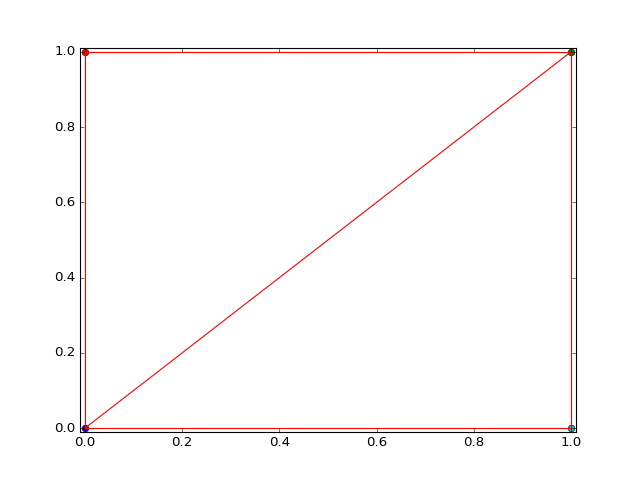

In [7]:
HC = Complex()
HC.I
HC.generate_vertex([0, 0])  # 0
HC.generate_vertex([1, 1])  # 1

# generate first edge
HC.generate_simplex([0, 1], k=1)

#----
# Move down once in first dimension:
HC.generate_vertex([0, 1])  # 2

# generate new edge between 1 and (new vertex)
HC.generate_simplex([1, HC.i_current[0] ]
                 , k=1)

# Move back to 0: New edge
HC.generate_simplex([0, HC.i_current[0] ], k=1)

# Finally get a k=2 simplex
# Generate k=2 simplex
HC.generate_simplex([0, 1, HC.i_current[0]], k=2)

#----
# Starting from V_1 = [1, 1], move down in the second dimension:
HC.generate_vertex([1, 0])  # 2

# generate new edge between 1 and (new vertex)
HC.generate_simplex([1, HC.i_current[0] ]
                 , k=1)

# Move back to 0: New edge
HC.generate_simplex([0, HC.i_current[0] ], k=1)

# Finally get a k=2 simplex
# Generate k=2 faces
HC.generate_simplex([0, 1, HC.i_current[0]], k=2)

# Print resulting structure
HC.print_complex()
HC.plot_graph()

In [8]:
from itertools import product
import itertools
import numpy
dim = 3

def generate_vertices(dim=3):
    print(list(product([0, 1], repeat=dim)))
    #vectorlist = list(product([0, 1], repeat=dim))
    vectors = numpy.array(list(product([0, 1], repeat=dim)))
    vectors, vectors[0], vectors.shape
    print(vectors.shape)
    return vectors

#vectors = numpy.array(list(product([0, 1], [0, 1], [0, 1]))) 
#print(list(product([0, 1], [0, 1], [0, 1])))
#print(list(product([0, 1], repeat=3)))
#vectors, vectors[0], vectors[3**2 - 2]
#vectors[3**2 - 2]
V = generate_vertices(dim)

#vectors = numpy.array(list(product([0, 1], repeat=6)))
#vectors, vectors[0], vectors.shape
V, V[1:-1,:]

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
(8, 3)


(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]), array([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0]]))

In [57]:
#ORDERING TEST:
V_ordered = [[0, 0, 0]]
for v in V[1:-1,:]:
    if (numpy.sum(v) > 0) and (numpy.sum(v) < 2):
        V_ordered.append(list(v))
        
for v in V[1:-1,:]:
    if (numpy.sum(v) > 1) and (numpy.sum(v) < 3):
        V_ordered.append(list(v))

V_ordered.append(V[-1])
V_ordered
V = numpy.array(V_ordered)
V

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 1],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

In [58]:
# Construct group iterators
groups = []
rows = []
#dim = 3

infininum = (2**dim - 2) 
intspace =  int(infininum / (dim - 1))
#^(Tested for the first n=10 hypercubes; shit works and always produces ints)
for g in range(dim - 1):
    #inds = 1 + g * (2**dim - 1) 
    inds = 1 + g * intspace
    #indf = (1 + g) * (2**dim - 1) 
    indf = (1 + g) * intspace
    groups.append(list(range(inds, indf + 1)))
    print(groups)
    rows.append(list(itertools.permutations(groups[g]))) 
    
print(rows)

[[1, 2, 3]]
[[1, 2, 3], [4, 5, 6]]
[[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)], [(4, 5, 6), (4, 6, 5), (5, 4, 6), (5, 6, 4), (6, 4, 5), (6, 5, 4)]]


In [69]:
#list(itertools.permutations([1, 2, 3], [4, 5, 6]))
#print(list(product([0, 1], [0, 1], [0, 1])))
groups2 = list(itertools.product([1, 2, 3], [4, 5, 6]))
groups2
groups2 = [(1, 4), (1, 5), (2, 4), (2, 6), (3, 5), (3, 6)]  # Fudge by deleting
groups2

[(1, 4), (1, 5), (2, 4), (2, 6), (3, 5), (3, 6)]

In [83]:
# Construct simplexes forming the minimum triangulation
import math

#for g in groups2:
S = []
I_S = []
for i in range(math.factorial(dim)):  # n! simplices
    S.append([])
    I_S.append([])
    S[i].append(list(V[0]))
    I_S[i].append(0)

    for d in range(dim - 1):
        S[i].append(list(V[groups2[i][d]]))
        I_S[i].append(groups2[i][d])


    S[i].append(list(V[-1]))
    I_S[i].append(2**dim)
    S[i] = numpy.array(S[i])
        
print(S)
print(I_S)

[array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 0, 1],
       [1, 0, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 1, 0],
       [0, 1, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 1, 0],
       [1, 1, 0],
       [1, 1, 1]]), array([[0, 0, 0],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       [1, 1, 1]])]
[[0, 1, 4, 8], [0, 1, 5, 8], [0, 2, 4, 8], [0, 2, 6, 8], [0, 3, 5, 8], [0, 3, 6, 8]]


In [60]:
# Construct simplexes forming the minimum triangulation
import math
S = []
I_S = []
for i in range(math.factorial(dim)):  # n! simplices
    S.append([])
    I_S.append([])
    S[i].append(list(V[0]))
    I_S[i].append(0)
    #print(permutation_groups[i])
    for g in range(dim - 1):
        #print(rows[g][i])
        S[i].append(list(V[rows[g][i][0]]))
        I_S[i].append(rows[g][i][0])
        #for j in range(dim):
        #    print(V[rows[g][i][j]])        
        #    S[i].append(list(V[rows[g][i][j]]))
        #    I_S[i].append(rows[g][i][j])
    
    
    S[i].append(list(V[-1]))
    I_S[i].append(2**dim)
    S[i] = numpy.array(S[i])
        
print(S)
print(I_S)

[array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 1, 0],
       [1, 0, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 1, 0],
       [1, 0, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       [1, 1, 1]]), array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       [1, 1, 1]])]
[[0, 1, 4, 8], [0, 1, 4, 8], [0, 2, 5, 8], [0, 2, 5, 8], [0, 3, 6, 8], [0, 3, 6, 8]]


In [61]:
import itertools
permgroup = range(1, dim)
coords = [1, 2, 3]
coords = [1, 2, 3, 4]
permutation_groups = list(itertools.permutations(coords))
print(list(itertools.permutations(coords)))

[(1, 2, 3, 4), (1, 2, 4, 3), (1, 3, 2, 4), (1, 3, 4, 2), (1, 4, 2, 3), (1, 4, 3, 2), (2, 1, 3, 4), (2, 1, 4, 3), (2, 3, 1, 4), (2, 3, 4, 1), (2, 4, 1, 3), (2, 4, 3, 1), (3, 1, 2, 4), (3, 1, 4, 2), (3, 2, 1, 4), (3, 2, 4, 1), (3, 4, 1, 2), (3, 4, 2, 1), (4, 1, 2, 3), (4, 1, 3, 2), (4, 2, 1, 3), (4, 2, 3, 1), (4, 3, 1, 2), (4, 3, 2, 1)]


In [62]:
# simplices
import math
for i in range(math.factorial(dim)):  # n! simplices
    print(permutation_groups[i])
    print()

(1, 2, 3, 4)

(1, 2, 4, 3)

(1, 3, 2, 4)

(1, 3, 4, 2)

(1, 4, 2, 3)

(1, 4, 3, 2)



<IPython.core.display.Javascript object>


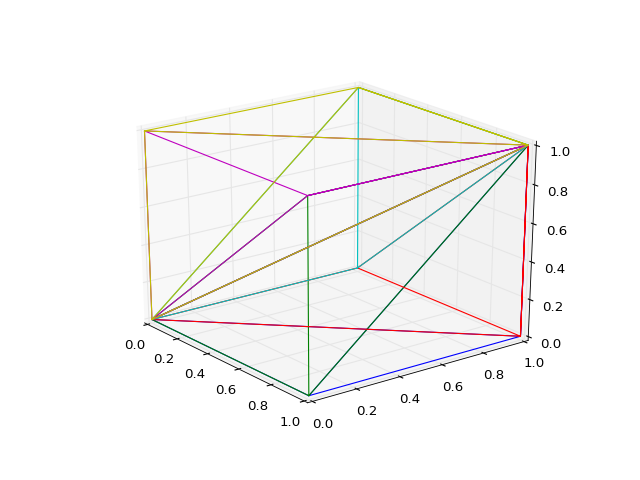

[[0 0 0]
 [1 0 0]
 [1 1 0]
 [1 1 1]]
[[0 0 0]
 [1 0 0]
 [1 0 1]
 [1 1 1]]
[[0 0 0]
 [0 1 0]
 [1 1 0]
 [1 1 1]]
[[0 0 0]
 [0 1 0]
 [0 1 1]
 [1 1 1]]
[[0 0 0]
 [0 0 1]
 [1 0 1]
 [1 1 1]]
[[0 0 0]
 [0 0 1]
 [0 1 1]
 [1 1 1]]


In [133]:
def print_simplex_3dim(S):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    #array([[0, 0, 0],
    #       [0, 0, 1],
    #       [1, 0, 0],
    #       [1, 1, 1]])
    
    # [rows, col]
    for s in S:
        #s = S[0]
        print(s)
        x = []
        y = []
        z = []
        for v in range(4):
            x.append(s[v, 0])
            y.append(s[v, 1])
            z.append(s[v, 2])

        # Lines from first with thrid vertex
        x.append(s[0][0])
        y.append(s[0][1])
        z.append(s[0][2])
        x.append(s[2][0])
        y.append(s[2][1])
        z.append(s[2][2])
        # Lines from last to second vertex
        x.append(s[3][0])
        y.append(s[3][1])
        z.append(s[3][2])
        x.append(s[1][0])
        y.append(s[1][1])
        z.append(s[1][2])

        ax.plot(x, y, z, label='simplex')
        #for v1 in range(len(s)):
            #for v2 in range(v1, len(s)):
                #x.append(s[v1][0])
                #y.append(s[v1][1])
                #z.append(s[v1][2])
                #x.append(s[v2][0])
                #y.append(s[v2][1])
                #z.append(s[v2][2])
                #print(x)

                #ax.plot(x, y, z, label='simplex')

print_simplex_3dim(S)

Build the D set feasible region to use for symmetery groups later:
==

In [88]:
# Domain := hypercube

list(itertools.permutations(range(dim)))

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

In [134]:
# Construct simplexes forming the minimum triangulation
dim = 5
import math
import numpy
D = [(0, 1),]*3


S = []
I_S = []
permgroups = list(itertools.permutations(range(dim)))
for tau in permgroups:  # n! simplices
    S.append([])
    I_S.append([])
    for j in range(dim):
        S[i].append([d[0] for d in D])
    
    for i in range(dim):
        for j in range(dim):
            S[i][j] = S[i][j]
        #S[i].append(list(V[rows[g][i][0]]))

    
    
    S[i].append(list(V[-1]))
    I_S[i].append(2**dim)
    S[i] = numpy.array(S[i])
        
print(S)
print(I_S)

IndexError: list index out of range

In [94]:
[d[0] for d in D]

[0, 0, 0]

In [95]:
permgroups = list(itertools.permutations(range(dim)))
permgroups

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

In [123]:
import math
import numpy
D = [[0, 1],]*3
D = numpy.array(D)

S = []
for tau in permgroups:  # n! simplices
    V = numpy.tile(D[:, 0], (dim + 1, 1))
    #S.append([])
    #I_S.append([])

    for i in range(dim):
        for j in range(dim):
            V[i + 1] = V[i]  # (Needed since looping through i will )
        
        V[i + 1][tau[i]] = D[tau[i], 1]

    
    
    #S[i].append(list(V[-1]))
    #I_S[i].append(2**dim)
    #S[i] = numpy.array(S[i])
    print(V)
    S.append(V)

print(S)

[[0 0 0]
 [1 0 0]
 [1 1 0]
 [1 1 1]]
[[0 0 0]
 [1 0 0]
 [1 0 1]
 [1 1 1]]
[[0 0 0]
 [0 1 0]
 [1 1 0]
 [1 1 1]]
[[0 0 0]
 [0 1 0]
 [0 1 1]
 [1 1 1]]
[[0 0 0]
 [0 0 1]
 [1 0 1]
 [1 1 1]]
[[0 0 0]
 [0 0 1]
 [0 1 1]
 [1 1 1]]
[array([[0, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       [1, 1, 1]]), array([[0, 0, 0],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 1, 0],
       [1, 1, 0],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 1, 0],
       [0, 1, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 0, 1],
       [1, 0, 1],
       [1, 1, 1]]), array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 1],
       [1, 1, 1]])]


<IPython.core.display.Javascript object>


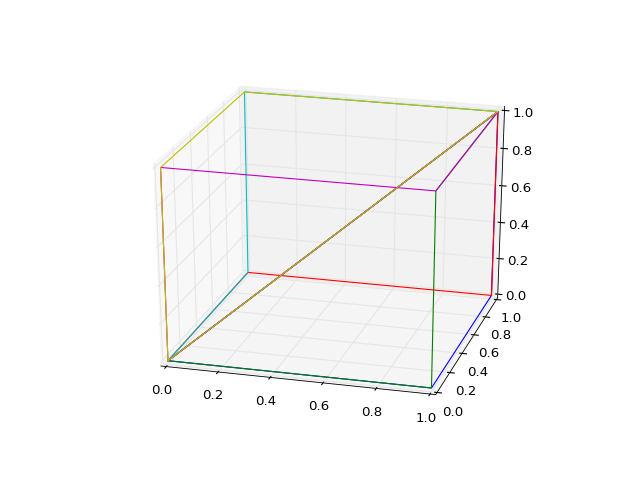

[[0 0 0]
 [1 0 0]
 [1 1 0]
 [1 1 1]]
[0, 1, 1, 1, 0]
[0, 0, 1, 1, 0]
[[0 0 0]
 [1 0 0]
 [1 0 1]
 [1 1 1]]
[0, 1, 1, 1, 0]
[0, 0, 0, 1, 0]
[[0 0 0]
 [0 1 0]
 [1 1 0]
 [1 1 1]]
[0, 0, 1, 1, 0]
[0, 1, 1, 1, 0]
[[0 0 0]
 [0 1 0]
 [0 1 1]
 [1 1 1]]
[0, 0, 0, 1, 0]
[0, 1, 1, 1, 0]
[[0 0 0]
 [0 0 1]
 [1 0 1]
 [1 1 1]]
[0, 0, 1, 1, 0]
[0, 0, 0, 1, 0]
[[0 0 0]
 [0 0 1]
 [0 1 1]
 [1 1 1]]
[0, 0, 0, 1, 0]
[0, 0, 1, 1, 0]


In [125]:
print_simplex_3dim(S)

In [127]:
D[:, 1]

array([1, 1, 1])